In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/dataset.zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")

print("Extraction Done")
print(os.listdir("/content/"))


Extraction Done
['.config', 'drive', 'dataset', 'sample_data']


In [ ]:
print(os.listdir("/content/dataset"))


['train', 'validate', 'test']


In [ ]:
import os

print("Main folders:", os.listdir("/content/dataset"))
print("Train classes:", os.listdir("/content/dataset/train"))
print("Val classes:", os.listdir("/content/dataset/validate"))
print("Test classes:", os.listdir("/content/dataset/test"))


Main folders: ['train', 'validate', 'test']
Train classes: ['0', '1']
Val classes: ['0', '1']
Test classes: ['0', '1']


In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import os


In [ ]:
TRAIN_DIR = "/content/dataset/train"
VAL_DIR   = "/content/dataset/validate"
TEST_DIR  = "/content/dataset/test"

In [ ]:
print("Train classes:", os.listdir(TRAIN_DIR))

Train classes: ['0', '1']


In [ ]:
# 5️⃣ Config
# =========================
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 6

# =========================
# 6️⃣ Data Generators
# =========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

print("Train samples:", len(train_gen.filenames))
print("Validation samples:", len(val_gen.filenames))
print("Test samples:", len(test_gen.filenames))

Found 60000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Train samples: 60000
Validation samples: 20000
Test samples: 20000


In [ ]:
# 7️⃣ Model (V1 Architecture)
# =========================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,521 (91.20 MB)

 Trainable params: 23,907,521 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 8️⃣ Callbacks
# =========================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/ai_image_detector_large_gpu.h5",
    save_best_only=True,
    monitor='val_loss'
)

# =========================
# 9️⃣ Train
# =========================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6812 - loss: 0.6004

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 246s 127ms/step - accuracy: 0.6812 - loss: 0.6003 - val_accuracy: 0.8259 - val_loss: 0.3902
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8305 - loss: 0.3958

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 207s 111ms/step - accuracy: 0.8305 - loss: 0.3958 - val_accuracy: 0.8748 - val_loss: 0.2999
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8754 - loss: 0.3106

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 213s 114ms/step - accuracy: 0.8754 - loss: 0.3106 - val_accuracy: 0.9018 - val_loss: 0.2575
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8955 - loss: 0.2681

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 207s 110ms/step - accuracy: 0.8955 - loss: 0.2681 - val_accuracy: 0.9064 - val_loss: 0.2418
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 198s 105ms/step - accuracy: 0.9070 - loss: 0.2428 - val_accuracy: 0.9078 - val_loss: 0.2427
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9189 - loss: 0.2192

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 197s 105ms/step - accuracy: 0.9189 - loss: 0.2192 - val_accuracy: 0.9094 - val_loss: 0.2211


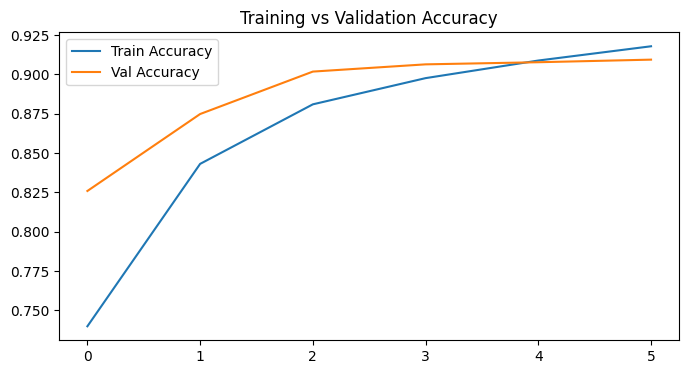

625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 74ms/step

=== TEST RESULTS ===
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     10000
           1       0.91      0.92      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



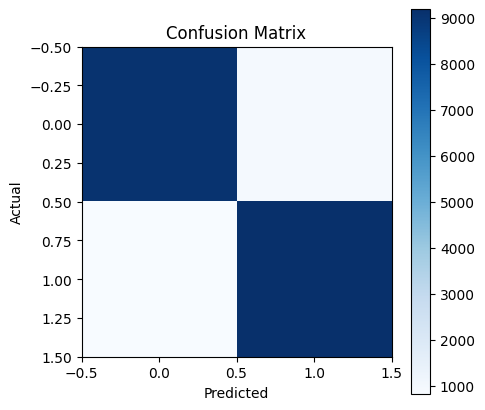

✅ Model saved 


In [ ]:
# 🔟 Plot Accuracy
# =========================
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

# =========================
# 1️⃣1️⃣ Test Evaluation
# =========================
preds = (model.predict(test_gen) > 0.5).astype("int32")

print("\n=== TEST RESULTS ===")
print(classification_report(test_gen.classes, preds))

cm = confusion_matrix(test_gen.classes, preds)

plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

print("✅ Model saved ")

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [ ]:
#2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import os


In [ ]:
TRAIN_DIR = "/content/dataset/train"
VAL_DIR   = "/content/dataset/validate"
TEST_DIR  = "/content/dataset/test"

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 6

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_gen = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_gen = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 60000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [ ]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

# Freeze base model
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/ai_image_detector_mobilenet.h5",
    save_best_only=True,
    monitor="val_loss"
)


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7005 - loss: 0.5749

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 236s 113ms/step - accuracy: 0.7005 - loss: 0.5749 - val_accuracy: 0.7793 - val_loss: 0.4684
Epoch 2/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7778 - loss: 0.4704

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 200s 107ms/step - accuracy: 0.7778 - loss: 0.4704 - val_accuracy: 0.7898 - val_loss: 0.4481
Epoch 3/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7913 - loss: 0.4463

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 213s 114ms/step - accuracy: 0.7913 - loss: 0.4463 - val_accuracy: 0.7934 - val_loss: 0.4346
Epoch 4/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7988 - loss: 0.4310

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 202s 107ms/step - accuracy: 0.7988 - loss: 0.4310 - val_accuracy: 0.8008 - val_loss: 0.4254
Epoch 5/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8017 - loss: 0.4221

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 198s 105ms/step - accuracy: 0.8017 - loss: 0.4221 - val_accuracy: 0.8025 - val_loss: 0.4203
Epoch 6/6
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8137 - loss: 0.4090

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 197s 105ms/step - accuracy: 0.8137 - loss: 0.4090 - val_accuracy: 0.8057 - val_loss: 0.4142


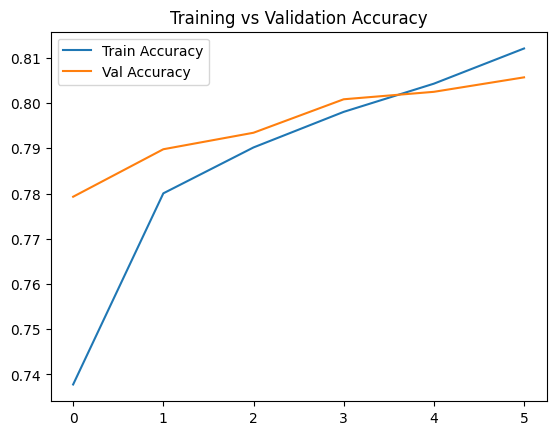

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


625/625 ━━━━━━━━━━━━━━━━━━━━ 50s 71ms/step

=== TEST RESULTS ===
              precision    recall  f1-score   support

           0       0.79      0.82      0.81     10000
           1       0.82      0.79      0.80     10000

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000



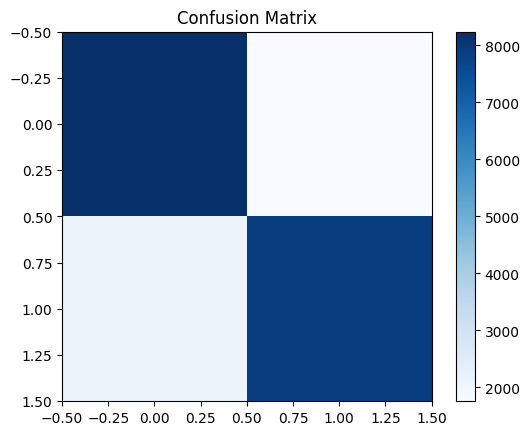

In [ ]:
preds = (model.predict(test_gen) > 0.5).astype("int32")

print("\n=== TEST RESULTS ===")
print(classification_report(test_gen.classes, preds))

cm = confusion_matrix(test_gen.classes, preds)

plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()
